Churn Prediction Model

Loading the datasets

In [38]:
from pathlib import Path
import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# parent directory to path to import src module
sys.path.insert(0, str(Path.cwd().parent))

import src.unimib_snowit_project.utils as u

In [39]:
DATA_PKL_DIR = 'data_loaded'

USERS_PKL_FILENAME = 'users.pkl'
PROFILES_PKL_FILENAME = 'profiles.pkl'
CARDS_PKL_FILENAME = 'cards.pkl'
ORDERS_PKL_FILENAME = 'orders.pkl'
ORDER_DETAILS_PKL_FILENAME = 'order_details.pkl'

root_dir_path = u.get_root_dir() 

data_pkl_dir_path = root_dir_path / DATA_PKL_DIR
users_pkl_path = data_pkl_dir_path / USERS_PKL_FILENAME
profiles_pkl_path = data_pkl_dir_path / PROFILES_PKL_FILENAME
cards_pkl_path = data_pkl_dir_path / CARDS_PKL_FILENAME
orders_pkl_path = data_pkl_dir_path / ORDERS_PKL_FILENAME
order_details_pkl_path = data_pkl_dir_path / ORDER_DETAILS_PKL_FILENAME

def load_pkl(pkl_path):
    with pkl_path.open('rb') as fh:
        return dill.load(fh)

users_df = load_pkl(users_pkl_path)
profiles_df = load_pkl(profiles_pkl_path)
cards_df = load_pkl(cards_pkl_path)
orders_df = load_pkl(orders_pkl_path)
order_details_df = load_pkl(order_details_pkl_path)


Churn Distribution
preparing the datasets (merging) .  Building the order_kpi dataset

In [40]:
print("--- Building order_kpi from cleaned PKL data ---")

# Keep only fulfilled items for revenue
order_details_clean = order_details_df[order_details_df["item.status"] == "fulfilled"].copy()

# Parse order dates
orders_df["createdAt"] = pd.to_datetime(orders_df["createdAt"])

# Join order_details → orders
od_orders = order_details_clean.merge(
    orders_df[["order.uid", "user.uid", "createdAt", "source", "tenant"]],
    on="order.uid",
    how="left"
)

# Revenue per item
od_orders["item_revenue"] = od_orders["item.amount"].astype(float)

# Aggregate to order level
order_kpi = (
    od_orders
    .groupby("order.uid", as_index=False)
    .agg(
        user_uid=("user.uid", "first"),
        order_date=("createdAt", "first"),
        source=("source", "first"),
        tenant=("tenant", "first"),
        order_revenue=("item_revenue", "sum")
    )
)

order_kpi.head()


--- Building order_kpi from cleaned PKL data ---


,order.uid,user_uid,order_date,source,tenant,order_revenue
0,0013wz6tllybz6dczg,z3t5ctevz3qpnnetsbusgbc5qu,2023-12-09,app,snowit,32.0
1,001ar3c4lxvfkbzd3h,ecgsdgxexzoysahonss2wx4pmi,2024-02-03,website,snowit,168.0
2,001lwhyxkqfaisi7ll,woypybkscvrplitnuwpzrl3knd,2023-02-08,website,snowit_esterno,627.2
3,001mdurceg4exzah8t,jixtqm2shcppjcqxdqolsdph5p,2025-02-07,website,snowit_esterno,34.0
4,001pf8tqssr6hpviox,jf7kdg4zskzkmv1nu4vya2sbdd,2024-01-01,website,snowit_esterno,53.0


Define churn with a proper cut-off

Let snapshot_date = max(order_date) (end of data).

Choose a churn period (90 days).

Define T0 = snapshot_date − churn_period.

Features will be computed from orders before T0.

A customer is churned if they have no order between T0 and snapshot_date

In [41]:
print("\n--- Defining churn label with cut-off ---")

CHURN_PERIOD_DAYS = 90

snapshot_date = order_kpi["order_date"].max()
cutoff_date = snapshot_date - pd.Timedelta(days=CHURN_PERIOD_DAYS)

print("Snapshot date:", snapshot_date)
print("Feature cut-off date (T0):", cutoff_date)

# Orders BEFORE T0 (for features)
orders_before = order_kpi[order_kpi["order_date"] < cutoff_date].copy()

# Orders BETWEEN T0 and snapshot_date (to see who is active later)
orders_after = order_kpi[
    (order_kpi["order_date"] >= cutoff_date) &
    (order_kpi["order_date"] <= snapshot_date)
].copy()

# Last order date over the whole period (for churn label)
last_order_overall = (
    order_kpi.groupby("user_uid")["order_date"]
    .max()
    .rename("last_order_date")
    .reset_index()
)

# Churn label: 1 = churned (no order after cutoff), 0 = active
last_order_overall["churned"] = (last_order_overall["last_order_date"] < cutoff_date).astype(int)

last_order_overall["churned"].value_counts()



--- Defining churn label with cut-off ---
Snapshot date: 2025-02-15 00:00:00
Feature cut-off date (T0): 2024-11-17 00:00:00


churned
1    79106
0    69016
Name: count, dtype: int64

displaying the churn distribution


--- Plotting Churn vs Active Customers ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_23396\3578061678.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


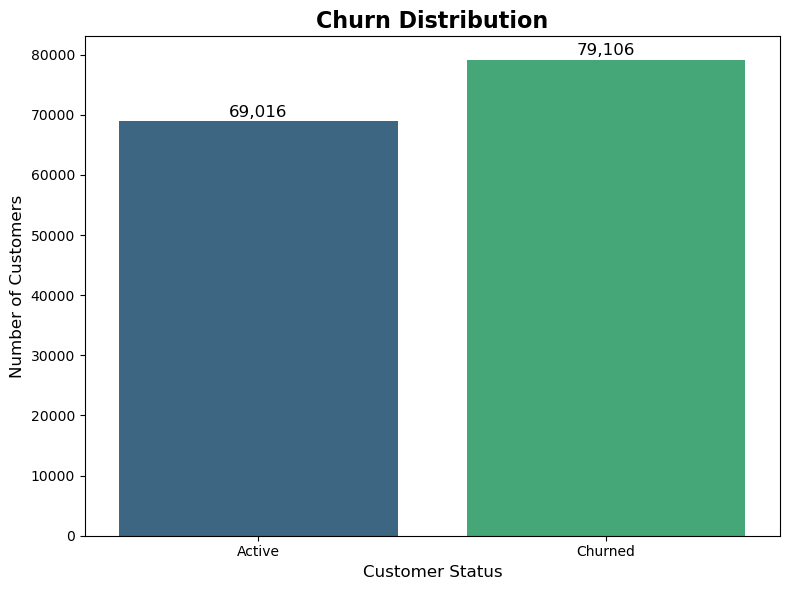

In [49]:


print("\n--- Plotting Churn vs Active Customers ---")

# Count churn distribution
churn_counts = last_order_overall["churned"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(
    x=churn_counts.index.map({0: "Active", 1: "Churned"}),
    y=churn_counts.values,
    palette="viridis"
)

plt.title("Churn Distribution", fontsize=16, weight="bold")
plt.xlabel("Customer Status", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Add labels on top of bars
for i, value in enumerate(churn_counts.values):
    plt.text(i, value + (value * 0.01), f"{value:,}", ha="center", fontsize=12)

plt.tight_layout()
plt.show()


Feature engineering using ONLY orders_before

In [42]:
print("\n--- Building behavioral features (pre-T0 only) ---")

# Basic aggregations before cutoff
agg_before = (
    orders_before
    .groupby("user_uid")
    .agg(
        first_order_date=("order_date", "min"),
        last_order_before_T0=("order_date", "max"),
        freq_total=("order.uid", "nunique"),
        monetary_total=("order_revenue", "sum")
    )
    .reset_index()
)

# Tenure: how long they've been a customer before T0
agg_before["tenure_days"] = (cutoff_date - agg_before["first_order_date"]).dt.days

# Average order value
agg_before["avg_order_value"] = agg_before["monetary_total"] / agg_before["freq_total"]

# Orders in last 30 days before T0
window_start_30 = cutoff_date - pd.Timedelta(days=30)

orders_last_30 = (
    orders_before[
        (orders_before["order_date"] >= window_start_30) &
        (orders_before["order_date"] < cutoff_date)
    ]
    .groupby("user_uid")["order.uid"]
    .nunique()
    .rename("orders_last_30d")
    .reset_index()
)

# Merge that into main feature table
features_behavior = agg_before.merge(orders_last_30, on="user_uid", how="left")
features_behavior["orders_last_30d"] = features_behavior["orders_last_30d"].fillna(0)

features_behavior.head()



--- Building behavioral features (pre-T0 only) ---


,user_uid,first_order_date,last_order_before_T0,freq_total,monetary_total,tenure_days,avg_order_value,orders_last_30d
0,002cjigqy3zbbtaehc5a7f0iod,2023-02-11,2023-02-11,1,150.0,645,150.000000,0.0
1,005bg1dx4mxrhsdjqmpwxr4rni,2024-03-28,2024-03-28,1,101.0,234,101.000000,0.0
2,00a3sq7bg9xnyotnmsqkmyjhgt,2023-02-07,2023-02-08,2,60.0,649,30.000000,0.0
3,00bcwo2xxxya7mdn6morwb9z83,2023-12-08,2023-12-08,1,240.7,345,240.700000,0.0
4,00ddoynhcteoamva9axq2yrg8n,2024-01-26,2024-03-17,3,277.0,296,92.333333,0.0


Adding churn label & user/profile info

In [43]:
print("\n--- Adding churn label and user/profile information ---")

# Rename for join
users_ren = users_df.rename(columns={"user.uid": "user_uid"})
profiles_ren = profiles_df.rename(columns={"user.uid": "user_uid"})

user_profile = (
    profiles_ren
    .groupby("user_uid", as_index=False)
    .agg(
        main_city=("city", "first"),
        sex=("sex", "first"),
        level=("level", "first")
    )
)

# Merge behavior features + churn label
features_df = (
    features_behavior
    .merge(last_order_overall[["user_uid", "churned"]], on="user_uid", how="inner")
    .merge(users_ren, on="user_uid", how="left")
    .merge(user_profile, on="user_uid", how="left")
)

print("Features_df shape:", features_df.shape)
features_df.head()



--- Adding churn label and user/profile information ---
Features_df shape: (101748, 25)
Features_df shape: (101748, 25)


,user_uid,first_order_date,last_order_before_T0,freq_total,monetary_total,tenure_days,avg_order_value,orders_last_30d,churned,createdAt,...,googleId,appleId,facebookId,referral.medium,referral.source,referral.type,favouriteZones,main_city,sex,level
0,002cjigqy3zbbtaehc5a7f0iod,2023-02-11,2023-02-11,1,150.0,645,150.000000,0.0,1,2022-12-07,...,True,<NA>,<NA>,None,None,<NA>,[],NaN,NaN,<NA>
1,005bg1dx4mxrhsdjqmpwxr4rni,2024-03-28,2024-03-28,1,101.0,234,101.000000,0.0,1,2024-03-28,...,<NA>,<NA>,<NA>,None,None,<NA>,[],NaN,NaN,<NA>
2,00a3sq7bg9xnyotnmsqkmyjhgt,2023-02-07,2023-02-08,2,60.0,649,30.000000,0.0,1,2023-02-07,...,True,<NA>,<NA>,None,None,<NA>,[],NaN,NaN,<NA>
3,00bcwo2xxxya7mdn6morwb9z83,2023-12-08,2023-12-08,1,240.7,345,240.700000,0.0,1,2023-12-08,...,True,<NA>,<NA>,None,None,<NA>,[],NaN,NaN,<NA>
4,00ddoynhcteoamva9axq2yrg8n,2024-01-26,2024-03-17,3,277.0,296,92.333333,0.0,0,2024-01-26,...,True,<NA>,<NA>,None,None,<NA>,[],NaN,NaN,<NA>


Choosing features for the model

In [44]:
print("\n--- Selecting modeling features ---")

candidate_num = ["freq_total", "monetary_total", "tenure_days", "avg_order_value", "orders_last_30d"]
candidate_cat = ["source", "language", "sex", "level", "main_city"]

num_features = [c for c in candidate_num if c in features_df.columns]
cat_features = [c for c in candidate_cat if c in features_df.columns]

print("Numerical features:", num_features)
print("Categorical features:", cat_features)



--- Selecting modeling features ---
Numerical features: ['freq_total', 'monetary_total', 'tenure_days', 'avg_order_value', 'orders_last_30d']
Categorical features: ['source', 'language', 'sex', 'level', 'main_city']


Building a clean design matrix

In [45]:
import numpy as np

print("\n--- Building X_final and y ---")

# Work on a copy and normalize missing values
features_df_clean = features_df.replace({pd.NA: np.nan})

# Numeric part
X_num = features_df_clean[num_features].astype("float64")
X_num_imputed = X_num.fillna(X_num.median())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_imputed),
    columns=num_features,
    index=features_df_clean.index
)

# Categorical part
X_cat = features_df_clean[cat_features].astype("string")
X_cat_imputed = X_cat.fillna("Missing")
X_cat_dummies = pd.get_dummies(X_cat_imputed, drop_first=False)

# Final feature matrix
X_final = pd.concat([X_num_scaled, X_cat_dummies], axis=1)

# Target
y = features_df_clean["churned"].astype(int)

print("X_final shape:", X_final.shape)
print("Target distribution:\n", y.value_counts())



--- Building X_final and y ---
X_final shape: (101748, 400)
Target distribution:
 churned
1    79106
0    22642
Name: count, dtype: int64
X_final shape: (101748, 400)
Target distribution:
 churned
1    79106
0    22642
Name: count, dtype: int64


plotting churn Distribution


--- Plotting Churn Distribution ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_23396\2211849968.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


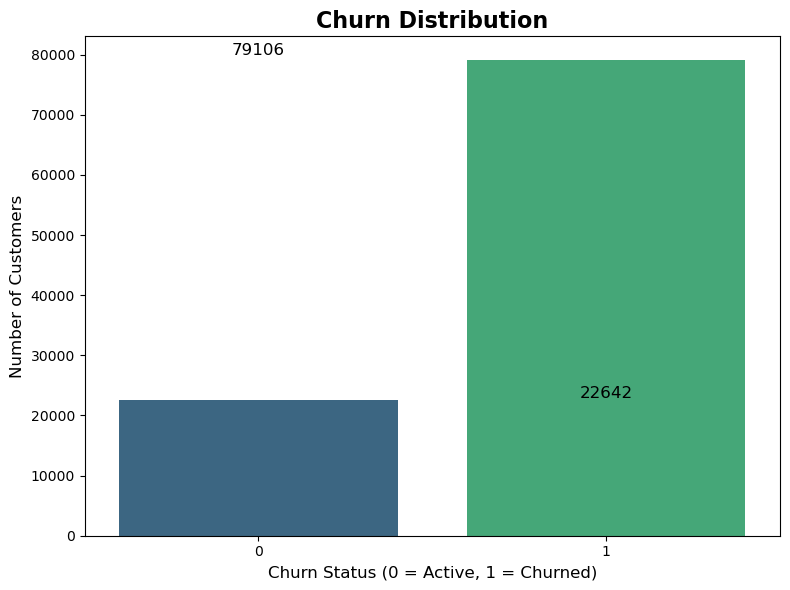

In [47]:
print("\n--- Plotting Churn Distribution ---")

plt.figure(figsize=(8, 6))

# Create a countplot
sns.countplot(x=y, palette="viridis")

plt.title("Churn Distribution", fontsize=16, weight="bold")
plt.xlabel("Churn Status (0 = Active, 1 = Churned)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

# Display values on bars
counts = y.value_counts()
for idx, value in enumerate(counts):
    plt.text(idx, value + (value * 0.01), str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Training Logistic Regression and Random Forest for the churn prediction model

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

print("\n--- Train/test split ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

print("\n--- Training and evaluating models (NO LEAKAGE) ---")
for name, model in models.items():
    print(f"\n▶ Model: {name}")
    
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        "model": model,
        "roc_auc": auc,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

print("\n--- Model ROC-AUC Comparison ---")
for name, res in results.items():
    print(f"{name}: {res['roc_auc']:.4f}")



--- Train/test split ---

--- Training and evaluating models (NO LEAKAGE) ---

▶ Model: LogisticRegression

--- Training and evaluating models (NO LEAKAGE) ---

▶ Model: LogisticRegression
ROC-AUC: 0.7930
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.29      0.40      6793
           1       0.82      0.96      0.89     23732

    accuracy                           0.81     30525
   macro avg       0.74      0.62      0.64     30525
weighted avg       0.79      0.81      0.78     30525


▶ Model: RandomForest
ROC-AUC: 0.7930
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.29      0.40      6793
           1       0.82      0.96      0.89     23732

    accuracy                           0.81     30525
   macro avg       0.74      0.62      0.64     30525
weighted avg       0.79      0.81      0.78     30525


▶ Model: RandomForest
ROC-AUC: 0.7569
Classification r